![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de árboles de decisión y métodos de ensamblaje

En este taller podrá poner en práctica los sus conocimientos sobre construcción e implementación de árboles de decisión y métodos de ensamblajes. El taller está constituido por 9 puntos, 5 relacionados con árboles de decisión (parte A) y 4 con métodos de ensamblaje (parte B).

## Parte A - Árboles de decisión

En esta parte del taller se usará el conjunto de datos de Capital Bikeshare de Kaggle, donde cada observación representa el alquiler de bicicletas durante una hora y día determinado. Para más detalles puede visitar los siguientes enlaces: [datos](https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip), [dicccionario de datos](https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset#).

### Datos prestamo de bicicletas

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, export_graphviz

In [3]:
# Lectura de la información de archivo .csv
bikes = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/bikeshare.csv', index_col='datetime', parse_dates=True)

# Renombrar variable "count" a "total"
bikes.rename(columns={'count':'total'}, inplace=True)

# Crear la hora como una variable 
bikes['hour'] = bikes.index.hour

# Visualización de los datos
bikes.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,hour
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4


### Punto 1 - Análisis descriptivo

Ejecute las celdas 1.1 y 1.2. A partir de los resultados realice un análisis descriptivo sobre las variables "season" y "hour", escriba sus inferencias sobre los datos. Para complementar su análisis puede usar métricas como máximo, mínimo, percentiles entre otros.

In [4]:
# Celda 1.1
bikes.groupby('season').total.mean()

season
1    116.343261
2    215.251372
3    234.417124
4    198.988296
Name: total, dtype: float64

In [5]:
# Celda 1.2
display(bikes.groupby('hour').total.mean())

horas_bici = bikes.groupby('hour').total.mean().reset_index()
minimo = horas_bici.loc[horas_bici['total'] == min(horas_bici['total']), :]
maximo = horas_bici.loc[horas_bici['total'] == max(horas_bici['total']), :]

print('\nLa hora en la que existe menor demanda de bicicletas es a las ' + str(minimo.iloc[0, 0]) + ' horas, con un promedio de ' + str(minimo.iloc[0, 1]) + 'bicicletas rentadas.')
print('\nLa hora en la que existe una mayor demanda de bicicletas es a las ' + str(maximo.iloc[0, 0]) + ' horas, con un promedio de ' + str(maximo.iloc[0, 1]) + 'bicicletas rentadas.')


hour
0      55.138462
1      33.859031
2      22.899554
3      11.757506
4       6.407240
5      19.767699
6      76.259341
7     213.116484
8     362.769231
9     221.780220
10    175.092308
11    210.674725
12    256.508772
13    257.787281
14    243.442982
15    254.298246
16    316.372807
17    468.765351
18    430.859649
19    315.278509
20    228.517544
21    173.370614
22    133.576754
23     89.508772
Name: total, dtype: float64


La hora en la que existe menor demanda de bicicletas es a las 4 horas, con un promedio de 6.407239819004525bicicletas rentadas.

La hora en la que existe una mayor demanda de bicicletas es a las 17 horas, con un promedio de 468.765350877193bicicletas rentadas.


La variable **season** indica la temporada en la cual se realizó el alquiler de bicicletas: 1 (invierno), 2 (primavera), 3 (verano) y 4 (otoño). Se puede observar que en invierno se suelen rentar la menor cantidad de bicicletas, con un promedio de 116 bicicletas por hora. Otoño es la segunda época con menor número de alquileres, con 198 bicicletas rentadas por hora. Por otro lado, primavera y verano son las temporadas en las que más se alquilan bicicletas, con un promedio de bicicletas rentadas por hora de 215 y 234 respectivamente. Al analizar esta variable se puede resaltar que la demanda de bicicletas es mayor en épocas con clima más agradable.

En lo que respecta a la variable **hour**, se puede analizar la demanda de bicicletas por cada una de las horas del día. Según el promedio de bicicletas rentadas por cada hora, se puede observar que las horas en las que existe una menor demanda son las horas de la madrugada, mientras que la mayor demanda coincide con las horas de entrada y salida del horario laboral, de hecho, la hora en la que existe mayor demanda es a las 17 horas con un promedio de 468 bicicletas y la hora en la que existe menor demanda es a las 4 horas con un promedio de 6 bicicletas.

### Punto 2 - Análisis de gráficos

Primero ejecute la celda 2.1 y asegúrese de comprender el código y el resultado. Luego, en cada una de celdas 2.2 y 2.3 escriba un código que genere una gráfica del número de bicicletas rentadas promedio para cada valor de la variable "hour" (hora) cuando la variable "season" es igual a 1 (invierno) e igual a 3 (verano), respectivamente. Analice y escriba sus hallazgos.

<Axes: xlabel='hour'>

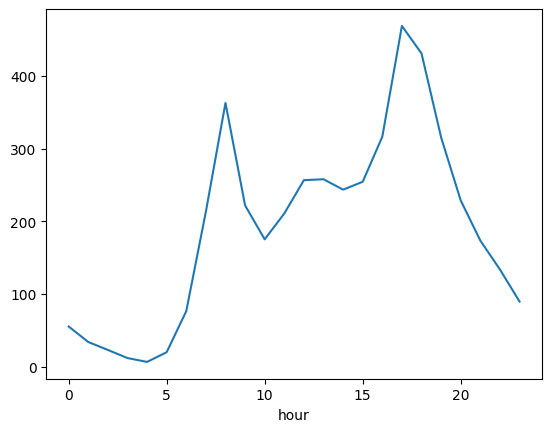

In [6]:
# Celda 2.1 - rentas promedio para cada valor de la variable "hour"
bikes.groupby('hour').total.mean().plot()

<Axes: xlabel='hour'>

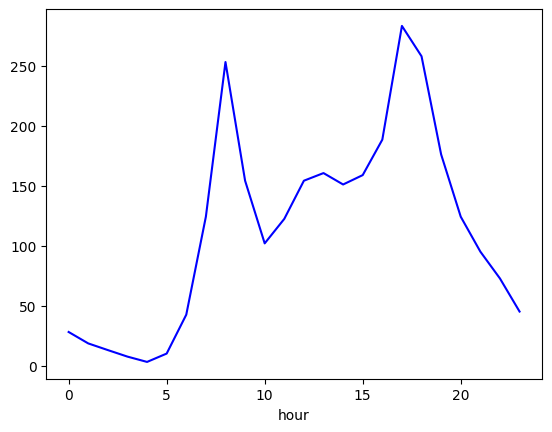

In [7]:
# Celda 2.2 - "season"=1 escriba su código y hallazgos 
bikes.loc[bikes['season'] == 1, :].groupby('hour').total.mean().plot(color = "blue")

<Axes: xlabel='hour'>

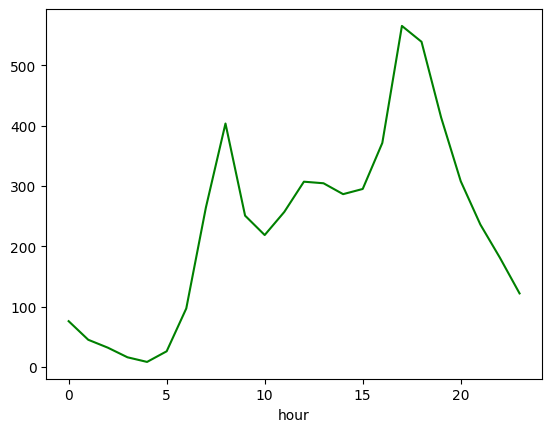

In [8]:
# Celda 2.3 - "season"=3 escriba su código y hallazgos 
bikes.loc[bikes['season'] == 3, :].groupby('hour').total.mean().plot(color = "green")

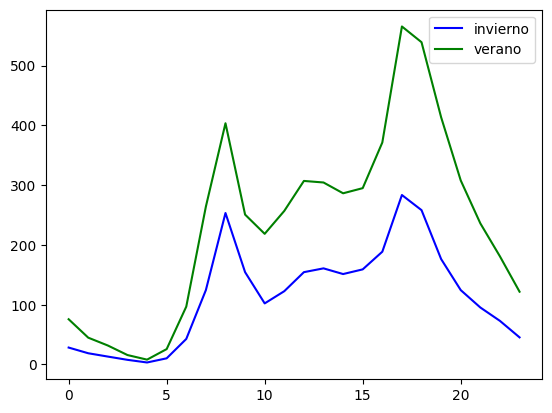

In [9]:
import matplotlib.pyplot as plt 

demanda_por_season = bikes.groupby(['hour', 'season']).total.mean().reset_index()

plt.plot(demanda_por_season.loc[demanda_por_season['season'] == 1, 'hour'], demanda_por_season.loc[demanda_por_season['season'] == 1, 'total'], label = "invierno", color = "blue", linestyle="-") 
plt.plot(demanda_por_season.loc[demanda_por_season['season'] == 3, 'hour'], demanda_por_season.loc[demanda_por_season['season'] == 3, 'total'], label = "verano", color = "green", linestyle="-") 
plt.legend() 
plt.show()

Al analizar la demanda promedio de bicicletas según la hora del día y la temporada, se puede observar que el comportamiento estacional durante las horas del día es similar tanto para invierno como verano, ambos muestran una distribución con alta demanda en las horas de entrada y salida del horario laboral. Sin embargo, como se resaltó anteriormente, en verano existe una demanda mayor, lo que se puede observar en el gráfico combinado donde la línea verde (demanda de verano) tiene una forma similar a la línea azul (demanda de invierno), pero tiene valores superiores.

### Punto 3 - Regresión lineal
En la celda 3 ajuste un modelo de regresión lineal a todo el conjunto de datos, utilizando "total" como variable de respuesta y "season" y "hour" como las únicas variables predictoras, teniendo en cuenta que la variable "season" es categórica. Luego, imprima los coeficientes e interprételos. ¿Cuáles son las limitaciones de la regresión lineal en este caso?

In [10]:
# Celda 3

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Transformo la variable categórica a dummies
dummy_variables = pd.get_dummies(bikes['season'], drop_first=True, prefix='season').astype(int)
bikes_con_dummies = pd.concat([bikes.loc[:, ['hour', 'total']], dummy_variables], axis=1)

# Separo las variables dependientes de las independientes
X = bikes_con_dummies.loc[:, bikes_con_dummies.columns != 'total']
y = bikes_con_dummies['total']

# Calculo los coeficientes
model = LinearRegression()
print("COEFICIENTES:")
print(list(X.columns))
model.fit(X, y)
print(model.coef_)

#Separo en entrenamiento y muestra
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

# Estimo el modelo de nuevo y calculo el desempeño
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("\nMean Squared Error:", mse)

COEFICIENTES:
['hour', 'season_2', 'season_3', 'season_4']
[ 10.54520609 100.31723192 119.46754995  84.08311787]

Mean Squared Error: 26473.647170373013


Después de ajustar el modelo de regresión lineal podemos observar que el coeficiente para la variable **hour** es 10.54, para **season_2** es de 100.32, para **season_3** 119.47 y para **season_4** es 84.08. Esto se puede interpretar como:

- Por cada hora que pasa en el día, existe un incremento de la demanda de biciletas de 10.54.
- Si la temporada es season_2 (primavera), la demanda será 100 bicicletas mayor.
- Si la temporada es season_3 (verano), la demanda será 119 bicicletas mayor.
- Si la temporada es season_4 (otoño), la demanda será 84 bicicletas mayor.

Aunque para las variables de las temporadas el modelo parece tener una interpretación lógica para los coeficientes, no sucede lo mismo con la variable de la hora, ya que, como se observó anteriormente, la demanda no es estrictamente creciente a lo largo del día, sino que hay una elevada demanda en la entrada del horario laboral y otro incremento a la salida del horario laboral. Esto es una demostración de las limitantes de la regresión lineal, pues no es posible capturar los comportamientos **no lineales** de los predictores de manera sencilla. 

### Punto 4 - Árbol de decisión manual
En la celda 4 cree un árbol de decisiones para pronosticar la variable "total" iterando **manualmente** sobre las variables "hour" y  "season". El árbol debe tener al menos 6 nodos finales.

In [11]:
# Celda 4

# Definición de la función mse para calular el mse 
def get_mse(X_col, y, split):
    
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]

    #En caso no haya datos en alguno de los nodos, saco el mse solo del que si tiene
    mse_l = 0
    mse_r = 0
    if n_l != 0:
        mse_l = np.mean((y_l - np.mean(y_l)) ** 2)
    if n_r != 0:
        mse_r = np.mean((y_r - np.mean(y_r)) ** 2)
    
    mse = (n_l / (n_l + n_r) * mse_l) + (n_r / (n_l + n_r) * mse_r)
    
    return mse

# Definición de la función best_split para calcular cuál es la mejor variable y punto de corte para hacer la bifurcación del árbol
def best_split(X, y, num_pct=10):
    
    features = range(X.shape[1])
    
    best_split = [0, 0, -1]  # j, split, mse
    
    # Para todas las varibles 
    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        #En caso haya mas de una particion
        if len(splits) > 0:
            # Para cada partición
            for split in splits:
                mse = get_mse(X.iloc[:, j], y, split)
                if best_split[2] == -1:
                    best_split = [j, split, mse]
                elif mse < best_split[2]:
                    best_split = [j, split, mse]
        
        #Si solo hay una particion, solo le saco el mse
        else:
            splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
            split = np.unique(splits)[0]
            mse = get_mse(X.iloc[:, j], y, split)
            
            if best_split[2] == -1:
                best_split = [j, split, mse]
            elif mse < best_split[2]:
                best_split = [j, split, mse]
            
    
    return best_split

# Definición de la función tree_grow para hacer un crecimiento recursivo del árbol
def tree_grow(X, y, level=0, min_mse=0, max_depth=None, num_pct=10):
    
    # Si solo es una observación
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], level=level, split=-1, n_samples=1, mse=0)
        return tree
    
    # Calcular la mejor división
    j, split, mse = best_split(X, y, num_pct)
    
    # Guardar el árbol y estimar la predicción
    y_pred = int(y.mean()) 
    
    tree = dict(y_pred=y_pred, level=level, split=-1, n_samples=X.shape[0], mse=mse)
    # Revisar el criterio de parada 
    if mse < min_mse:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # Continuar creando la partición
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # En caso de que hayan datos, busco la siguiente iteración para cada partición
    if len(X_l) > 0:
        tree['sl'] = tree_grow(X_l, y_l, level + 1, min_mse=min_mse, max_depth=max_depth, num_pct=num_pct)
    if len(X_r) > 0:
        tree['sr'] = tree_grow(X_r, y_r, level + 1, min_mse=min_mse, max_depth=max_depth, num_pct=num_pct)
    
    return tree

In [12]:
# Estimo el arbol. Para que tenga al menos 6 nodos establezco el mse minimo en 0 y la profundidad maxima en 3
arbol_punto4 = tree_grow(X, y, level=0, min_mse=0, max_depth=3, num_pct=10)
arbol_punto4

{'y_pred': 191,
 'level': 0,
 'split': [0, 8.0],
 'n_samples': 10886,
 'mse': 23675.892974467788,
 'sl': {'y_pred': 55,
  'level': 1,
  'split': [0, 7.0],
  'n_samples': 3594,
  'mse': 4569.219380357905,
  'sl': {'y_pred': 32,
   'level': 2,
   'split': [0, 6.0],
   'n_samples': 3139,
   'mse': 1242.1585299291187,
   'sl': {'y_pred': 25,
    'level': 3,
    'split': -1,
    'n_samples': 2684,
    'mse': 754.3758482230122},
   'sr': {'y_pred': 76,
    'level': 3,
    'split': -1,
    'n_samples': 455,
    'mse': 2849.677532032201}},
  'sr': {'y_pred': 213,
   'level': 2,
   'split': [2, 1.0],
   'n_samples': 455,
   'mse': 24424.406278497958,
   'sl': {'y_pred': 196,
    'level': 3,
    'split': -1,
    'n_samples': 341,
    'mse': 21737.005799149127},
   'sr': {'y_pred': 264,
    'level': 3,
    'split': -1,
    'n_samples': 114,
    'mse': 30497.823330255465}}},
 'sr': {'y_pred': 258,
  'level': 1,
  'split': [0, 21.0],
  'n_samples': 7292,
  'mse': 27620.291987504774,
  'sl': {'y_pre

In [13]:
# Definición de la función tree_predict para hacer predicciones según las variables 'X' y el árbol 'tree'

def tree_predict(X, tree):
    
    predicted = np.ones(X.shape[0])

    # Revisar si es el nodo final
    if tree['split'] == -1:
        predicted = predicted * tree['y_pred']
            
    else:
        
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  # Si el nodo izquierdo está vacio solo continua con el derecho 
            predicted[~filter_l] = tree_predict(X_r, tree['sr'])
        elif X_r.shape[0] == 0:  #  Si el nodo derecho está vacio solo continua con el izquierdo
            predicted[filter_l] = tree_predict(X_l, tree['sl'])
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'])
            predicted[~filter_l] = tree_predict(X_r, tree['sr'])

    return predicted


In [14]:
# Ejecución de función tree_predict
tree_predict(X, arbol_punto4)

array([ 25.,  25.,  25., ..., 153., 153.,  89.])

### Punto 5 - Árbol de decisión con librería
En la celda 5 entrene un árbol de decisiones con la **librería sklearn**, usando las variables predictoras "season" y "hour" y calibre los parámetros que considere conveniente para obtener un mejor desempeño. Recuerde dividir los datos en conjuntos de entrenamiento y validación para esto. Comente el desempeño del modelo con alguna métrica de desempeño de modelos de regresión y compare desempeño con el modelo del punto 3.

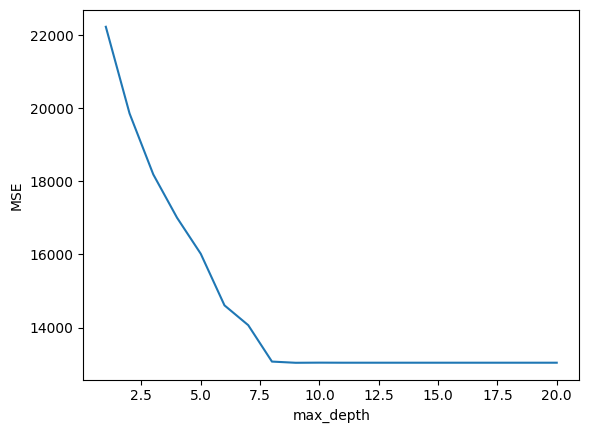

Mejor profundidad del árbol:  9
MSE del árbol: 13225.457029403828


In [15]:
# Celda 5
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor


# Lista de valores para calibrar el criterio de parada de máxima profundidad (max_depth)
max_depth_range = range(1, 21)

# Lista para guardar los valores del MSE para cada valor de máxima profundidad (max_depth)
mse_scores = []

# Loop para obtener el desempeño del modelo de acuerdo con la máxima profundidad
for depth in max_depth_range:
    # Definición del árbol de decisión usando DecisionTreeRegressor de la libreria sklearn
    dt = DecisionTreeRegressor(max_depth=depth, random_state=1)
    mse_scores.append(-cross_val_score(dt, X_train, y_train, cv=10, scoring='neg_mean_squared_error').mean())

# Gráfica max_depth versus MSE (error del modelo)
plt.plot(max_depth_range, mse_scores)
plt.xlabel('max_depth')
plt.ylabel('MSE')
plt.show()

# Mejor MSE (desempeño del modelo) y su correspondiente max_depth
mejor_depth = sorted(zip(mse_scores, max_depth_range))[0]

# Se ajusta un árbol usando este valor el mejor depth
dt = DecisionTreeRegressor(max_depth=mejor_depth[1], random_state=1)
dt.fit(X_train, y_train)

#Evaluamos el desempeño del modelo
y_pred = dt.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mejor profundidad del árbol: ", mejor_depth[1])
print("MSE del árbol:", mse)

Al entrenar un árbol de decisiones con la librería sklearn, se obtuvo que el MSE con una profundidad de 9 es 13225.46, el cual es considerablemente inferior al MSE que se obtuvo para la regresión lineal en el punto 3 (26473.65). Esto resalta las fortalezas que tienen los árboles de decisión para representar relaciones no lineales en comparación a la regresión lineal.

## Parte B - Métodos de ensamblajes
En esta parte del taller se usará el conjunto de datos de Popularidad de Noticias Online. El objetivo es predecir si la notica es popular o no, la popularidad está dada por la cantidad de reacciones en redes sociales. Para más detalles puede visitar el siguiente enlace: [datos](https://archive.ics.uci.edu/ml/datasets/online+news+popularity).

### Datos popularidad de noticias

In [16]:
# Lectura de la información de archivo .csv
df = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/mashable.csv', index_col=0)
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,Popular
0,http://mashable.com/2014/12/10/cia-torture-rep...,28.0,9.0,188.0,0.732620,1.0,0.844262,5.0,1.0,1.0,...,0.200000,0.80,-0.487500,-0.60,-0.250000,0.9,0.8,0.4,0.8,1
1,http://mashable.com/2013/10/18/bitlock-kicksta...,447.0,7.0,297.0,0.653199,1.0,0.815789,9.0,4.0,1.0,...,0.160000,0.50,-0.135340,-0.40,-0.050000,0.1,-0.1,0.4,0.1,0
2,http://mashable.com/2013/07/24/google-glass-po...,533.0,11.0,181.0,0.660377,1.0,0.775701,4.0,3.0,1.0,...,0.136364,1.00,0.000000,0.00,0.000000,0.3,1.0,0.2,1.0,0
3,http://mashable.com/2013/11/21/these-are-the-m...,413.0,12.0,781.0,0.497409,1.0,0.677350,10.0,3.0,1.0,...,0.100000,1.00,-0.195701,-0.40,-0.071429,0.0,0.0,0.5,0.0,0
4,http://mashable.com/2014/02/11/parking-ticket-...,331.0,8.0,177.0,0.685714,1.0,0.830357,3.0,2.0,1.0,...,0.100000,0.55,-0.175000,-0.25,-0.100000,0.0,0.0,0.5,0.0,0


In [17]:
# Definición variable de interes y variables predictoras
X = df.drop(['url', 'Popular'], axis=1)
y = df['Popular']
y.mean()

0.5

In [18]:
# División de la muestra en set de entrenamiento y prueba
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

### Punto 6 - Árbol de decisión y regresión logística
En la celda 6 construya un árbol de decisión y una regresión logística. Para el árbol calibre al menos un parámetro y evalúe el desempeño de cada modelo usando las métricas de Accuracy y F1-Score.

In [19]:
# Celda 6

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score


############################ Árbol de decisión ######################################################
# Loop para obtener el desempeño del modelo de acuerdo con la máxima profundidad
max_depth_range = range(1, 21)
accuracy_scores = []
for depth in max_depth_range:
    clf = DecisionTreeClassifier(max_depth=depth, random_state=1)
    accuracy_scores.append(cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy').mean())
mejor_arbol = sorted(zip(accuracy_scores, max_depth_range))[::-1][0]

# Estimo el modelo con el parámetro encontrado
dt_classifier = DecisionTreeClassifier(max_depth= mejor_arbol[1])
dt_classifier.fit(X_train, y_train)

#Obtengo las métricas de desempeño
y_pred_dt = dt_classifier.predict(X_test)
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print("Precisión del árbol de decisión:", accuracy_dt)
dt_f1 = f1_score(y_test, y_pred_dt, average='weighted')
print("F1 score del árbol de decisión:", dt_f1)

############################ Regresión logística ####################################################
# Estimo el modelo con el parámetro encontrado
logreg_classifier = LogisticRegression()
logreg_classifier.fit(X_train, y_train)

#Obtengo las métricas de desempeño
y_pred_logreg = logreg_classifier.predict(X_test)
accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
print("Precisión de la regresión logística:", accuracy_logreg)
lr_f1 = f1_score(y_test, y_pred_logreg, average='weighted')
print("F1 score de la regresión logística:", lr_f1)



Precisión del árbol de decisión: 0.6453333333333333
F1 score del árbol de decisión: 0.6453289196958573
Precisión de la regresión logística: 0.6126666666666667
F1 score de la regresión logística: 0.6126231108428497


Según las métricas de accuracy y F-1, el modelo de árbol de decisión presenta un desempeño ligeramente superior al de la regresión logística, pues cuenta con un accuracy de 0.64 y un F-1 score de 0.64, en contraste al accuracy de 0.61 y F-1 score de 0.61 de la regresión logística. Cabe recalcar que la poca diferencia entre accuracy y F-1 score de cada modelo evidencia que el modelo no está favoreciendo en exceso ninguna clase en particular a expensas de otras.

### Punto 7 - Votación Mayoritaria
En la celda 7 elabore un esamble con la metodología de **Votación mayoritaria** compuesto por 300 muestras bagged donde:

-las primeras 100 muestras vienen de árboles de decisión donde max_depth tome un valor de su elección\
-las segundas 100 muestras vienen de árboles de decisión donde min_samples_leaf tome un valor de su elección\
-las últimas 100 muestras vienen de regresiones logísticas

Evalúe cada uno de los tres modelos de manera independiente utilizando las métricas de Accuracy y F1-Score, luego evalúe el ensamble de modelos y compare los resultados. 

Nota: 

Para este ensamble de 300 modelos, deben hacer votación mayoritaria. Esto lo pueden hacer de distintas maneras. La más "fácil" es haciendo la votación "manualmente", como se hace a partir del minuto 5:45 del video de Ejemplo práctico de emsablajes en Coursera. Digo que es la más fácil porque si hacen la votación mayoritaria sobre las 300 predicciones van a obtener lo que se espera.

Otra opción es: para cada uno de los 3 tipos de modelos, entrenar un ensamble de 100 modelos cada uno. Predecir para cada uno de esos tres ensambles y luego predecir como un ensamble de los 3 ensambles. La cuestión es que la votación mayoritaria al usar los 3 ensambles no necesariamente va a generar el mismo resultado que si hacen la votación mayoritaria directamente sobre los 300 modelos. Entonces, para los que quieran hacer esto, deben hacer ese último cálculo con cuidado.

Para los que quieran hacerlo como ensamble de ensambles, digo que se debe hacer el ensamble final con cuidado por lo siguiente. Supongamos que:

* para los 100 árboles del primer tipo, la votación mayoritaria es: 55% de los modelos predicen que la clase de una observación es "1"
* para los 100 árboles del segundo tipo, la votación mayoritaria es: 55% de los modelos predicen que la clase de una observación es "1"
* para las 100 regresiones logísticas, la votación mayoritaria es: 10% de los modelos predicen que la clase de una observación es "1"

Si se hace la votación mayoritaria de los 300 modelos, la predicción de esa observación debería ser: (100*55%+100*55%+100*10%)/300 = 40% de los modelos votan porque la predicción debería ser "1". Es decir, la predicción del ensamble es "0" (dado que menos del 50% de modelos predijo un 1).

Sin embargo, si miramos cada ensamble por separado, el primer ensamble predice "1", el segundo ensamble predice "1" y el último ensamble predice "0". Si hago votación mayoritaria sobre esto, la predicción va a ser "1", lo cual es distinto a si se hace la votación mayoritaria sobre los 300 modelos.

In [23]:
# Celda 7
from tqdm import tqdm
from sklearn import metrics


# Creación de 300 muestras de bootstrap
n_estimators = 300
np.random.seed(123)
n_samples = X_train.shape[0]
samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(n_estimators)]

# Entrenamiento de 300 modelos con las 300 muestras boostrap
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

np.random.seed(123) 
seeds = np.random.randint(1, 10000, size=n_estimators)

modelos = {}
for i in tqdm(range(n_estimators)):
    if i+1 <= 100:
        modelos[i] = DecisionTreeClassifier(max_features="sqrt", max_depth= 20, random_state=seeds[i])
        modelos[i].fit(X_train.iloc[samples[i]], y_train.iloc[samples[i]])
    elif i+1 <= 200:
        modelos[i] = DecisionTreeClassifier(max_features="sqrt", min_samples_leaf= 5, random_state=seeds[i])
        modelos[i].fit(X_train.iloc[samples[i]], y_train.iloc[samples[i]])
    else:
        modelos[i] = LogisticRegression(random_state=seeds[i])
        modelos[i].fit(X_train.iloc[samples[i]], y_train.iloc[samples[i]])

# Predicción para los datos del set de test con cada modelo
y_pred_df = pd.DataFrame(index=X_test.index, columns=list(range(n_estimators)))
for i in range(n_estimators):
    y_pred_df.iloc[:, i] = modelos[i].predict(X_test)

# Votación mayoritaria
y_pred = (y_pred_df.sum(axis=1) >= (n_estimators / 2)).astype(int)

# Desempeño al hacer votación mayoritaria
#Primero evaluamos los 3 modelos de manera independiente
y_pred1 = (y_pred_df.iloc[:, 0:99].sum(axis=1) >= (100 / 2)).astype(int)
y_pred2 = (y_pred_df.iloc[:, 100:199].sum(axis=1) >= (100 / 2)).astype(int)
y_pred3 = (y_pred_df.iloc[:, 200:299].sum(axis=1) >= (100 / 2)).astype(int)
print("Métricas de desempeño para árboles de decisión con max_depth 20:")
print("F-1 score: ", metrics.f1_score(y_pred1, y_test))
print("Accuracy: ", metrics.accuracy_score(y_pred1, y_test))
print("\nMétricas de desempeño para árboles de decisión con min_samples_leaf 5:")
print("F-1 score:", metrics.f1_score(y_pred2, y_test))
print("Accuracy: ", metrics.accuracy_score(y_pred2, y_test))
print("\nMétricas de desempeño para regresión logística:")
print("F-1 score:", metrics.f1_score(y_pred3, y_test))
print("Accuracy: ", metrics.accuracy_score(y_pred3, y_test))
print("\nMétricas de desempeño para ensamble:")
print("F-1 score:", metrics.f1_score(y_pred, y_test))
print("Accuracy: ", metrics.accuracy_score(y_pred, y_test))

100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:07<00:00, 39.70it/s]


Métricas de desempeño para árboles de decisión con max_depth 20:
F-1 score:  0.6613756613756614
Accuracy:  0.6586666666666666

Métricas de desempeño para árboles de decisión con min_samples_leaf 5:
F-1 score: 0.6503733876442634
Accuracy:  0.6566666666666666

Métricas de desempeño para regresión logística:
F-1 score: 0.6119402985074627
Accuracy:  0.6186666666666667

Métricas de desempeño para ensamble:
F-1 score: 0.6178861788617886
Accuracy:  0.624


Al evaluar el accuracy y el F-1 score de los modelos de foma independiente y del ensamblaje final podemos destacar que:

- El modelo de árbol de decisión con max_depth = 5 es el que presenta un mejor desempeño, seguido de los árboles de decisión con min_samples_leaf = 5 y finalmente por la regresión logística.
- El modelo de ensamblaje final tiene un desempeño inferior que los modelos de árboles pero superior que el modelo de regresión logística.
- La poca diferencia entre accuracy y F-1 score de cada modelo evidencia que el modelo no está favoreciendo en exceso ninguna clase en particular a expensas de otras.

### Punto 8 - Votación Ponderada
En la celda 8 elabore un ensamble con la metodología de **Votación ponderada** compuesto por 300 muestras bagged para los mismos tres escenarios del punto 7. Evalúe los modelos utilizando las métricas de Accuracy y F1-Score

In [24]:
# Celda 8

samples_oob = []
# Obtención de las observaciones fuera de la bolsa "out-of-bag" para cada muestra
for sample in samples:
    samples_oob.append(sorted(set(range(n_samples)) - set(sample)))

# Estimación de los errores OOB para cada clasificador
errors = np.zeros(n_estimators)
for i in range(n_estimators):
    y_pred_ = modelos[i].predict(X_train.iloc[samples_oob[i]])
    errors[i] = 1 - metrics.accuracy_score(y_train.iloc[samples_oob[i]], y_pred_)

# Obtención de los pesos alpha de cada modelo de acuerdo al error OOB
alpha = (1 - errors) / (1 - errors).sum()

# Ponderación de las predicciones con los pesos alpha
weighted_sum = ((y_pred_df) * alpha).sum(axis=1)
y_pred = (weighted_sum >= 0.5).astype(int)

# Desempeño
print("\nMétricas de desempeño para ensamble:")
print("F-1 score:", metrics.f1_score(y_pred, y_test))
print("Accuracy: ", metrics.accuracy_score(y_pred, y_test))


Métricas de desempeño para ensamble:
F-1 score: 0.6169491525423729
Accuracy:  0.6233333333333333


### Punto 9 - Comparación y análisis de resultados
En la celda 9 comente sobre los resultados obtenidos con las metodologías usadas en los puntos 7 y 8, compare los resultados y enuncie posibles ventajas o desventajas de cada una de ellas.

Los resultados muestran que el desempeño del ensamblaje mediante la técnica de votación mayoritaria arroja un nivel de precisión (accuracy) de 0.624 y un puntaje F1 de 0.618. Estos valores son inferiores en comparación con el desempeño obtenido utilizando exclusivamente árboles de decisión con una profundidad máxima de 20 o con una cantidad mínima de muestras en las hojas igual a 5. Este hallazgo sugiere que la combinación de diferentes modelos mediante la votación mayoritaria no logra mejorar significativamente la predicción en relación con los modelos individuales.

Además, es importante destacar que el ensamblaje de votación mayoritaria presenta un desempeño muy similar al de la votación ponderada, donde cada modelo contribuye con un peso diferente en la decisión final. Esto sugiere que la ponderación de los modelos no mejora sustancialmente la capacidad predictiva del ensambla en este caso.e.

Por último, se observa que el modelo de regresión logística exhibe un desempeño ligeramente inferior en comparación con los árboles de decisión. Esta diferencia en el rendimiento de los modelos individuales puede estar contribuyendo a afectar la eficacia del ensamblaje, ya que la inclusión de un modelo con menor capacidad predictiva puede diluir el poder predictivo general del ensamblaje.

En conclusión, estos resultados subrayan la importancia de seleccionar cuidadosamente los modelos base para el ensamblaje y sugieren que la combinación de modelos puede no siempre conducir a mejoras significativas en el rendimiento predictivo, especialmente si los modelos individuales no son igualmente competentes. Es fundamental realizar una evaluación exhaustiva de los modelos base y considerar estrategias alternativas de ensamblaje para maximizar la precisión y la generalización del modelo.